### Object Detection Classifier
### Name: Yi-Ting Yeh
### Date: 2020/12/10

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

In [2]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 60

## Data Preprocessing

In [3]:
# Download the dataset, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
# Normalize the data.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Model Defining

In [5]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

## Model Training

In [6]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [7]:
history = None  # For recording the history of training process.

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    shuffle=True)

Epoch 1/60
1563/1563 [==============================] - 157s 101ms/step - loss: 1.8054 - accuracy: 0.3343 - val_loss: 1.5300 - val_accuracy: 0.4462
Epoch 2/60
1563/1563 [==============================] - 148s 95ms/step - loss: 1.4982 - accuracy: 0.4578 - val_loss: 1.3758 - val_accuracy: 0.4986
Epoch 3/60
1563/1563 [==============================] - 138s 89ms/step - loss: 1.3653 - accuracy: 0.5128 - val_loss: 1.3292 - val_accuracy: 0.5270
Epoch 4/60
1563/1563 [==============================] - 138s 89ms/step - loss: 1.2676 - accuracy: 0.5495 - val_loss: 1.1944 - val_accuracy: 0.5771
Epoch 5/60
1563/1563 [==============================] - 138s 88ms/step - loss: 1.1924 - accuracy: 0.5792 - val_loss: 1.1492 - val_accuracy: 0.5959
Epoch 6/60
1563/1563 [==============================] - 139s 89ms/step - loss: 1.1308 - accuracy: 0.6005 - val_loss: 1.0646 - val_accuracy: 0.6281
Epoch 7/60
1563/1563 [==============================] - 139s 89ms/step - loss: 1.0805 - accuracy: 0.6229 - val_loss: 

## Model Evaluating

#### Model accuracy / loss curves

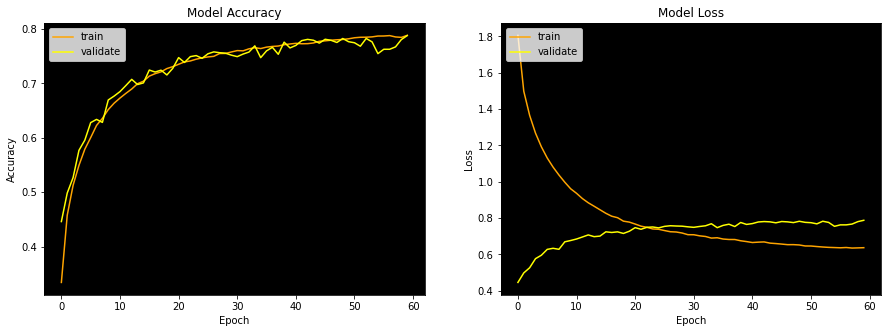

In [8]:
#Plot the model accuracy and model loss and their validates for each epoch
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], color="orange")
    axs[0].plot(history.history['val_accuracy'], color="yellow") 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].set_facecolor('xkcd:black')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], color="orange") 
    axs[1].plot(history.history['val_accuracy'], color="yellow") 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].set_facecolor('xkcd:black')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

plotmodelhistory(history)

#### Score of the trained model and its prediction

In [9]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

# make predictions.
pred = model.predict(x_test)

313/313 [==============================] - 6s 20ms/step - loss: 0.6384 - accuracy: 0.7881
Test accuracy: 0.788100004196167


#### Confusion Matrix by heatmap

In [10]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    # Show all ticks
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # Label ticks with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

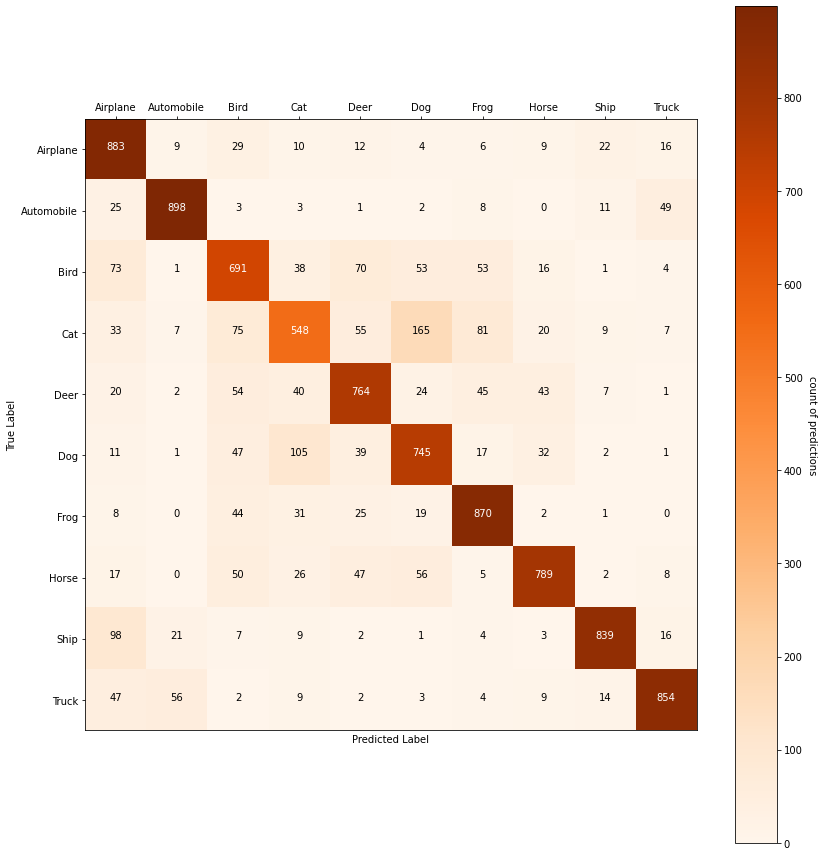

In [11]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax, cmap=plt.cm.Oranges, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

#### Report

In [12]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      1000
           1       0.90      0.90      0.90      1000
           2       0.69      0.69      0.69      1000
           3       0.67      0.55      0.60      1000
           4       0.75      0.76      0.76      1000
           5       0.69      0.74      0.72      1000
           6       0.80      0.87      0.83      1000
           7       0.85      0.79      0.82      1000
           8       0.92      0.84      0.88      1000
           9       0.89      0.85      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



#### Check correct Predictions

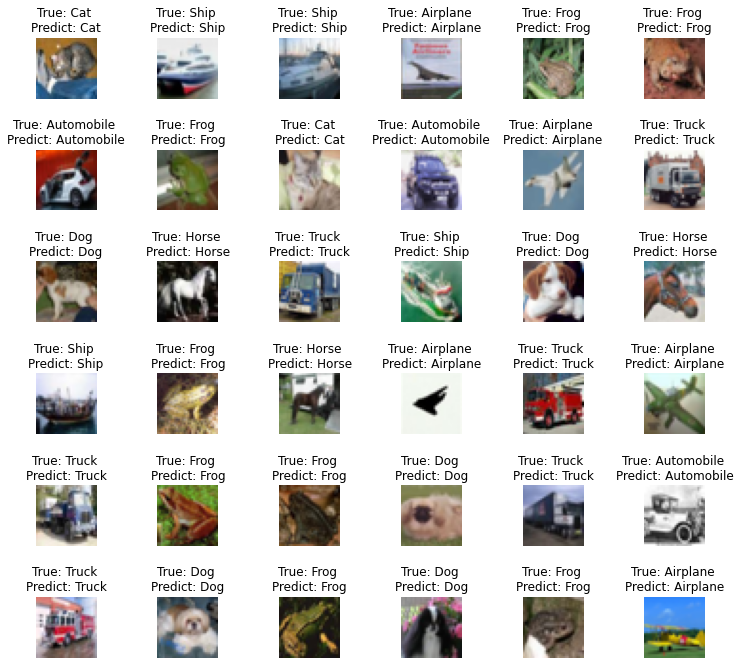

In [13]:
R = 6
C = 6
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

correctclassified_idx = np.where(Y_pred_classes == Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[correctclassified_idx[i]])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[correctclassified_idx[i]]],
                                                  labels[Y_pred_classes[correctclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

#### Check wrong predictions

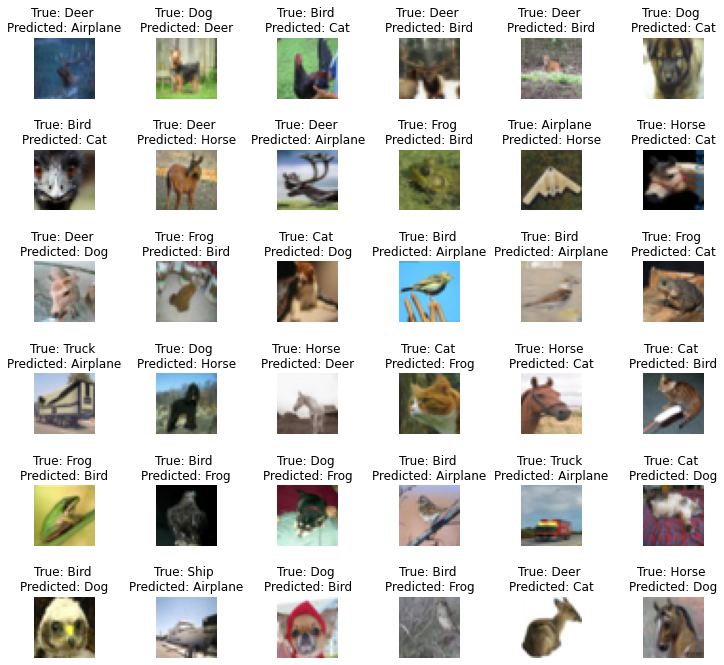

In [14]:
R = 6
C = 6
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                    labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)